Import used libraries and load input data:
- Photoluminescence
- Photoreflection

In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

pl07wr_df = pd.read_csv('data/PL_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pl07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl07wr_df = pl07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)
                     
pl25_df = pd.read_csv('data/PL_NP7811_laser_2p5mW.txt', sep='\t')
pl25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl25_df = pl25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr07wr_df = pd.read_csv('data/PR_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pr07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr07wr_df = pr07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr25_df = pd.read_csv('data/PR_NP7811_laser_2p5mW.txt', sep='\t')
pr25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr25_df = pr25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)


Fitting function for photoreflectance

$
\displaystyle
y(x) = A + Bx + Cx^2 + \frac{D_1}{\left( (x - E_1)^2 + {G_1}^2 \right)^{\frac{n}{2}}} \cdot \cos\left( T_1 - n\left( \frac{\pi}{2} - \tan^{-1}\left( \frac{x - E_1}{G_1} \right) \right) \right)
$

In [2]:
def fit_pr1_generic(n):
    def fit_pr1(x, A, B, C, D1, T1, E1, G1):
        term1 = A + B * x + C * x**2
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1))
        return term1 + (D1 / denom) * np.cos(angle)
    return fit_pr1

def fit_pr1_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
    }

def fit_pr1_reduced_generic(n):
    def fit_pr1_reduced(x, D1, T1, E1, G1):
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1))
        return (D1 / denom) * np.cos(angle)
    return fit_pr1_reduced

def fit_pr2_generic(n):
    def fit_pr2(x, A1, B1, C1, D1, T1, E1, G1, D2, T2, E2, G2):
        fit1 = fit_pr1_generic(n)(x, A1, B1, C1, D1, T1, E1, G1)
        fit2 = fit_pr1_reduced_generic(n)(x, D2, T2, E2, G2)
        return fit1 + fit2
    return fit_pr2

def fit_pr2_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
        'D2': params[7],
        'T2': params[8],
        'E2': params[9],
        'G2': params[10],
    }

Fitting function for module

$
\displaystyle
\frac{|\!D\!|}{\left( (x - E)^2 + G^2 \right)^{\frac{n}{2}}}
$

In [3]:
def fit_module_generic(n):
    def fit_module(x, D, E, G):
        denom = ((x - E)**2 + G**2)**(n / 2)
        return np.abs(D)/denom
    return fit_module

def fit_module1_calc(n, x, params_dict):
    D = params_dict['D1']
    E = params_dict['E1']
    G = params_dict['G1']
    return fit_module_generic(n)(x, D, E, G)

def fit_module2_calc(n, x, params_dict):
    D1 = params_dict['D1']
    E1 = params_dict['E1']
    G1 = params_dict['G1']
    fit1 = fit_module_generic(n)(x, D1, E1, G1)
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit1 + fit2

def fit_module12_calc(n, x, params_dict):
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit2

def fit_moduleN_calc(n, x, sd, params_dict):
    if sd == 1:
        return fit_module1_calc(n, x, params_dict)
    elif sd == 2:
        return fit_module2_calc(n, x, params_dict)
    else:
        raise Exception("Not supported")
        

Print all dataset to confirm everything is fine

In [4]:
print(f'Photoluminescence 0.7mW laser (wide-range): \n {pl07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')
print(f'Photoreflection 0.7mW laser: \n {pr07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')

Photoluminescence 0.7mW laser (wide-range): 
       energy          AC_X          AC_Y          AC_R      DC_R
0     1.0995 -2.185517e-07 -3.178930e-07  2.980247e-07  0.011333
1     1.1000 -4.371030e-07 -3.774987e-07  5.165773e-07  0.010222
2     1.1005 -1.351043e-06  8.742060e-07  1.589463e-06  0.011000
3     1.1010 -1.370910e-06  2.980250e-07  1.370913e-06  0.011000
4     1.1015 -7.748640e-07 -1.152363e-06  1.291440e-06  0.012444
...      ...           ...           ...           ...       ...
1196  1.6975 -7.351290e-07 -7.549957e-07  1.013288e-06  0.010444
1197  1.6980 -1.986830e-07 -3.178933e-07  3.377613e-07  0.010889
1198  1.6985  1.390783e-07 -1.152363e-06  1.092763e-06  0.010111
1199  1.6990 -5.761813e-07 -8.146017e-07  9.338137e-07  0.012444
1200  1.6995 -7.748640e-07 -1.668937e-06  1.768280e-06  0.013556

[1201 rows x 5 columns]
Photoluminescence 2.5mW laser: 
      energy          AC_X      AC_Y      AC_R      DC_R
0     1.099 -1.270330e-05  0.000082 -0.000084  0.020556
1   

In [5]:
from dataclasses import dataclass

@dataclass
class Result:
    # Name of result set
    name: str
    # Color used on charts
    color: str
    # Related energy range 
    energy_start: float
    energy_stop: float
    energy_idx_start: int
    energy_idx_stop: int
    # Single/Double fit
    sd: int
    # PR fit n
    n: int
    # Params fitted from PR
    fitted_params: {}
    covariance: [float]
    y_fitted: [float]
    x_fit: [float]

global_results_wr = {}
global_results_nr = {}

# Plotting

## Photoluminescence
Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

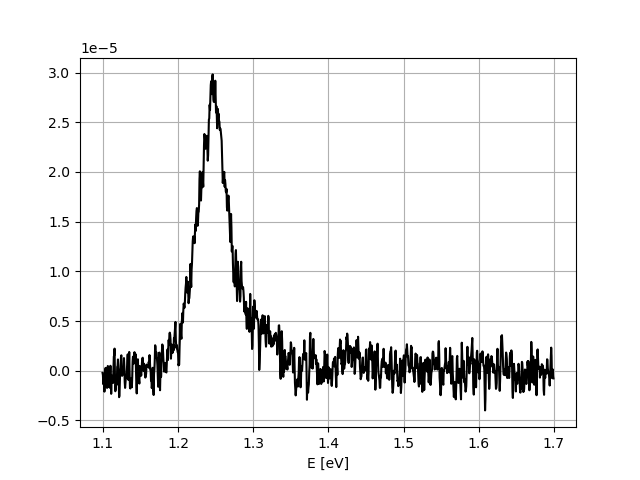

In [6]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']

plt.figure()
plt.plot(energy_wr, pl_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## Photoluminescence
Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

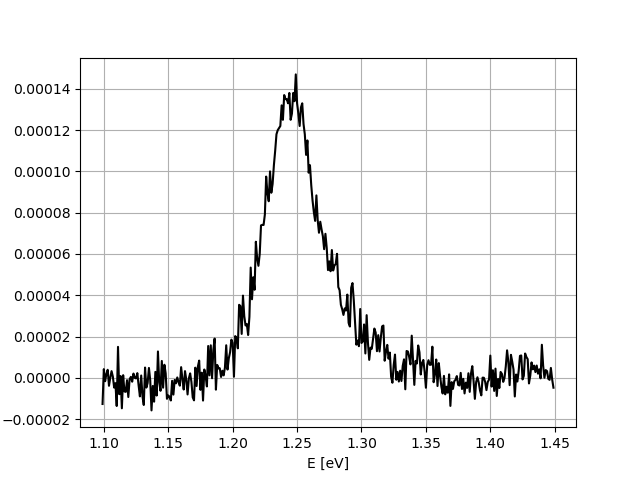

In [7]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']

plt.figure()
plt.plot(energy, pl, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Photoreflectance

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

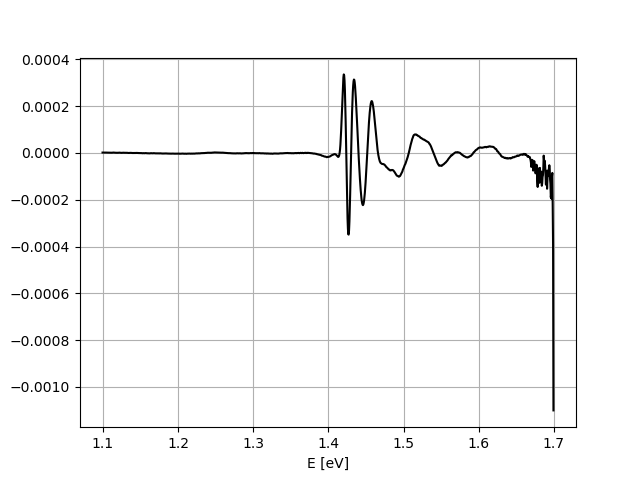

In [8]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']
pr_wr = pr07wr_df['AC_X']
r_wr = pr07wr_df['DC_R']
y_wr = (pr_wr-pl_wr)/r_wr

plt.figure()
plt.plot(energy_wr, y_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## I transition
Here I will try to fit function to first transition. \
Teacher advised me to use doubled fit function for the first transition.

Fitting from 1.415 eV to 1.4400507 eV, idx: 631, 681
Params [ 9.42258629e-01 -1.30293314e+00  4.50296872e-01  1.03925872e-09
 -2.29815357e+00  1.42298058e+00 -1.01181626e-02 -2.82294419e-09
 -3.39674559e+00  1.42841540e+00 -1.40708475e-02]
 Covariance: [[ 5.02957247e-01 -7.04065451e-01  2.46376262e-01  6.33868211e-11
  -1.34089067e-01  1.84004375e-04 -4.53164974e-05 -4.19660460e-10
  -1.25272135e-01  6.51884832e-05 -5.11379100e-04]
 [-7.04065451e-01  9.85588767e-01 -3.44891366e-01 -8.85914741e-11
   1.87731076e-01 -2.57574480e-04  6.32452329e-05  5.87191672e-10
   1.75469033e-01 -9.16806599e-05  7.15824132e-04]
 [ 2.46376262e-01 -3.44891366e-01  1.20689544e-01  3.09519698e-11
  -6.57025443e-02  9.01323657e-05 -2.20648522e-05 -2.05383409e-10
  -6.14397726e-02  3.22312599e-05 -2.50480055e-04]
 [ 6.33868211e-11 -8.85914741e-11  3.09519698e-11  2.05989840e-20
  -1.47319257e-11  2.40274082e-14 -2.30008532e-14 -7.62375609e-20
  -6.46090347e-12 -2.92728265e-14 -6.62424719e-14]
 [-1.34089067e-

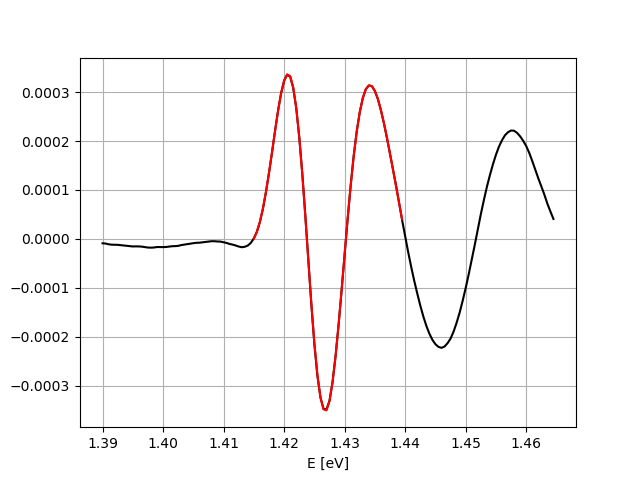

In [9]:
# Fitting range for the first transition
start_energy, stop_energy = 1.4150, 1.4400507

# Fitting params
n = 3
params1 = [
    1.30246864e+00,  #A1
    -1.80140004e+00, #B1 
    6.22648896e-01,  #C1
    7.56386049e-08,  #D1
    -3.57483951e+00, #T1 
    1.42247817e+00,  #E1
    -8.05044852e-03  #G1
]
params2 = [
    1.47047956e-07,  #D2
    -1.74818495e+00, #T2
    1.42897126e+00,  #E2
    -1.05916087e-02  #G2
]

# Double function used
fit_pr = fit_pr2_generic(n)

# Both-sided context
margin_idx = 50

start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1 + params2
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ff0000')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()
    
global_results_wr['T1'] = Result(
    name = 'PR WR I transition',
    color = '#ff0000',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 2,
    n = n,
    fitted_params = fit_pr2_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## II transition

[1.30246864, -1.80140004, 0.622648896, 7.56386049e-08, -3.57483951, 1.42247817, -0.00805044852, 1.47047956e-07, -1.74818495, 1.42897126, -0.0105916087]
Fitting from 1.4400507 eV to 1.466 eV, idx: 681, 733
Params [ 2.52539824e+00 -3.45693296e+00  1.18290788e+00  3.26041494e-09
 -2.70976449e+00  1.45278350e+00  1.83554509e-02]
 Covariance: [[ 1.48651680e-02 -2.04669929e-02  7.04436196e-03  7.09277549e-12
   4.83993289e-03  1.65578666e-05  7.41712120e-06]
 [-2.04669929e-02  2.81798850e-02 -9.69901882e-03 -9.75410380e-12
  -6.66546551e-03 -2.28041458e-05 -1.01979658e-05]
 [ 7.04436196e-03 -9.69901882e-03  3.33823841e-03  3.35321238e-12
   2.29469328e-03  7.85102007e-06  3.50504730e-06]
 [ 7.09277549e-12 -9.75410380e-12  3.35321238e-12  5.62234880e-21
   2.04165562e-12  6.85419419e-15  6.34716848e-15]
 [ 4.83993289e-03 -6.66546551e-03  2.29469328e-03  2.04165562e-12
   1.64718678e-03  5.70391397e-06  2.09160382e-06]
 [ 1.65578666e-05 -2.28041458e-05  7.85102007e-06  6.85419419e-15
   5.7039

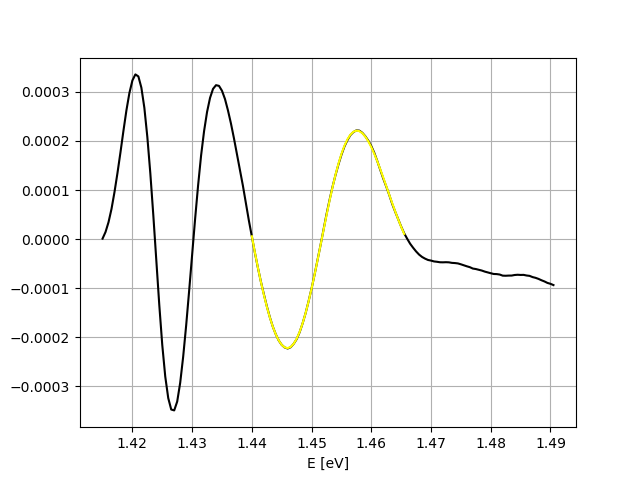

In [10]:
# Fitting range for the second transition
start_energy, stop_energy = 1.4400507, 1.466

# Fitting params
n = 3
params1 = [
    7.79067537e-01,  #A1
    -1.03719700e+00, #B1
    3.44798239e-01,  #C1
    1.72295879e-07,  #D1
    1.48424046e+00,  #T1
    1.45111328e+00,  #E1
    1.52253710e-02   #G1
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ffff00')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T2'] = Result(
    name = 'PR WR II transition',
    color = '#ffff00',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## III transition

[0.779067537, -1.037197, 0.344798239, 1.72295879e-07, 1.48424046, 1.45111328, 0.015225371]
Fitting from 1.466 eV to 1.541 eV, idx: 733, 883
Params [ 1.18560000e-02 -1.59669218e-02  5.36775959e-03  3.54227952e-09
 -1.92821026e-01  1.50717944e+00 -3.10693112e-02]
 Covariance: [[ 1.85257548e-04 -2.46864614e-04  8.22101741e-05 -1.20767107e-12
  -1.68540868e-03  1.22343229e-05  2.89113921e-06]
 [-2.46864614e-04  3.28965153e-04 -1.09553117e-04  1.62752818e-12
   2.24543411e-03 -1.62976786e-05 -3.89570348e-06]
 [ 8.22101741e-05 -1.09553117e-04  3.64844413e-05 -5.48070892e-13
  -7.47605805e-04  5.42558535e-06  1.31169109e-06]
 [-1.20767107e-12  1.62752818e-12 -5.48070892e-13  7.09017711e-20
   9.62868107e-12 -6.42015736e-14 -1.73245596e-13]
 [-1.68540868e-03  2.24543411e-03 -7.47605805e-04  9.62868107e-12
   1.69914927e-02 -1.27790645e-04 -2.34548212e-05]
 [ 1.22343229e-05 -1.62976786e-05  5.42558535e-06 -6.42015736e-14
  -1.27790645e-04  9.84826519e-07  1.57541647e-07]
 [ 2.89113921e-06 -3.89

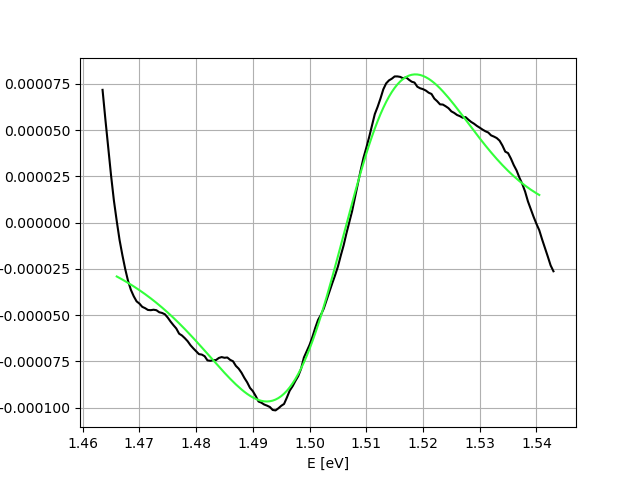

In [11]:
# Fitting range for the third transition
start_energy, stop_energy = 1.466, 1.541

# Fitting params
n = 3
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [
0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 5

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=100000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#33ff3a')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T3'] = Result(
    name = 'PR WR III transition',
    color = '#33ff3a',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## VI transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.541 eV to 1.5928 eV, idx: 883, 987
Params [ 1.12300265e+00 -1.43103990e+00  4.55722075e-01  9.29784361e-08
 -7.51386182e+00  1.56524050e+00 -6.00645499e-02]
 Covariance: [[ 2.44722659e-02 -3.12310892e-02  9.95815922e-03  6.06292419e-09
  -1.25743723e-02  1.07564127e-04 -6.33321665e-04]
 [-3.12310892e-02  3.98568887e-02 -1.27086272e-02 -7.73643047e-09
   1.61013100e-02 -1.37888398e-04  8.08127420e-04]
 [ 9.95815922e-03 -1.27086272e-02  4.05225892e-03  2.46648044e-09
  -5.15118374e-03  4.41625373e-05 -2.57640234e-04]
 [ 6.06292419e-09 -7.73643047e-09  2.46648044e-09  1.50994173e-15
  -2.95271066e-09  2.48050311e-11 -1.57956258e-10]
 [-1.25743723e-02  1.61013100e-02 -5.15118374e-03 -2.95271066e-09
   1.61413081e-02 -1.65864055e-04  3.07870741e-04]
 [ 1.07564127e-04 -1.37888398e-04  4.41625373e-05  2.48050311e-11
  -1.65864055e-04  1.73766550e-06 -2.58500673e-06]
 [-6.33321665e-04  8.08127420e-04 -2.57640234e-04 -1.57956258e-10
   3.078

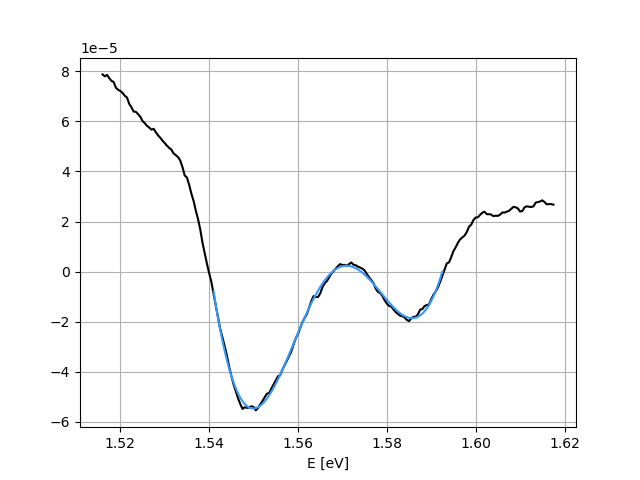

In [12]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.541, 1.5928

# Fitting params
n = 3
params1 = [
0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#3399ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T4'] = Result(
    name = 'PR WR IV transition',
    color = '#3399ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## V transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.5928 eV to 1.6617 eV, idx: 987, 1124
[-3.13913653e-02  3.86216880e-02 -1.18752024e-02  1.17800203e-09
 -3.75073342e+00  1.63040518e+00 -3.14337758e-02]


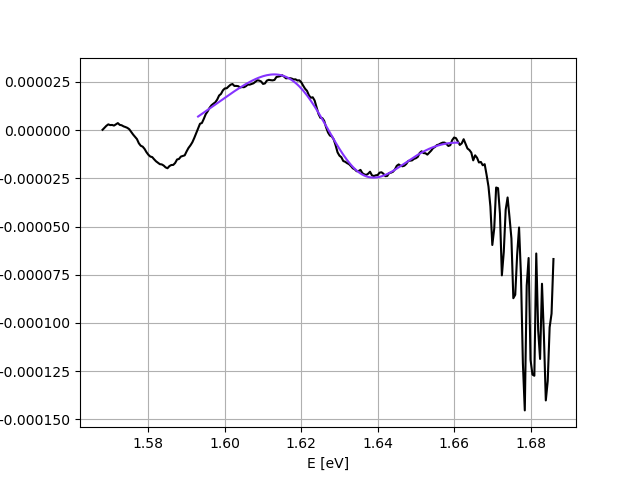

In [13]:
# Fitting range for the fifth transition
start_energy, stop_energy = 1.5928, 1.6617

# Fitting params
n = 3
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
y_fitted = fit_pr(x_fit, *params_final)

print(params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#8533ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T5'] = Result(
    name = 'PR WR V transition',
    color = '#8533ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

# All Transition 

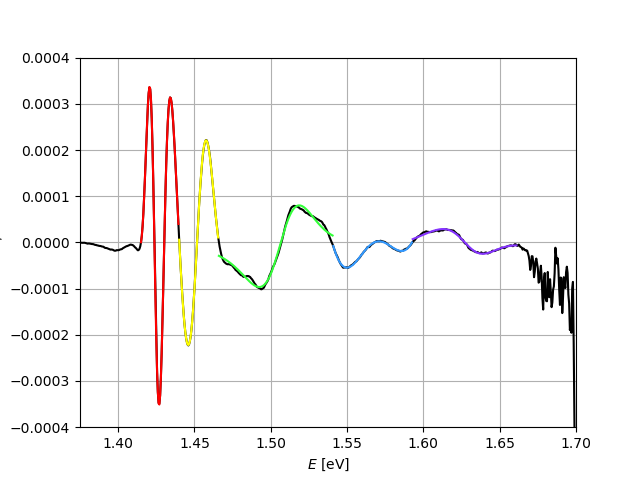

In [14]:
plt.figure()
# Plot base
plt.plot(energy_wr, y_wr, color='black')
# Apply results
for r in global_results_wr.values():
    plt.plot(r.x_fit, r.y_fitted, color=r.color)
plt.xlabel(r'$E $ [eV]')
plt.ylabel(r'$\Delta R / R$')
plt.ylim(-0.0004, 0.0004)
plt.xlim(1.375, 1.7)
plt.grid(True)
plt.show()


# Photoreflectance

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

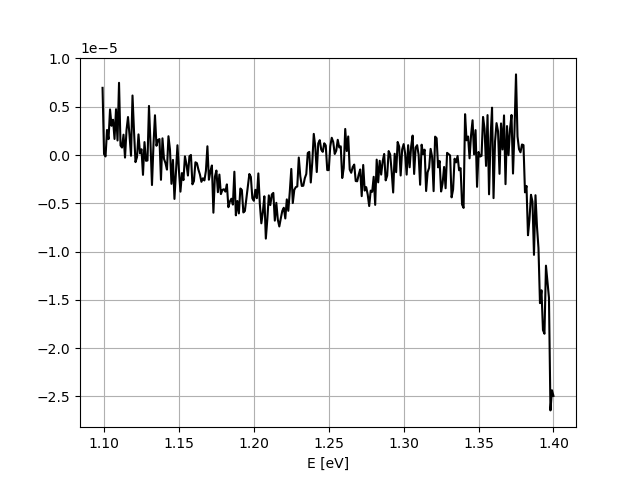

In [15]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']
pr = pr25_df['AC_X']
r = pr25_df['DC_R']
y_nr = (pr-pl)/r

plt.figure()
plt.plot(energy, y_nr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## I Transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.13 eV to 1.28 eV, idx: 31, 181
Params [ 5.41071702e-04 -8.66732267e-04  3.44265461e-04  6.13404655e-10
  1.06881202e+01  1.24691921e+00  4.79840467e-02]
 Covariance: [[ 1.21228995e-07 -2.04488382e-07  8.60969556e-08 -9.31080542e-14
   9.78391902e-05  8.24153485e-07 -1.98791172e-06]
 [-2.04488382e-07  3.44974914e-07 -1.45265809e-07  1.58181789e-13
  -1.64250994e-04 -1.37577971e-06  3.37572190e-06]
 [ 8.60969556e-08 -1.45265809e-07  6.11781173e-08 -6.70779552e-14
   6.88089568e-05  5.72932606e-07 -1.43081446e-06]
 [-9.31080542e-14  1.58181789e-13 -6.70779552e-14  1.08064301e-19
  -5.38996673e-11 -2.39847584e-13  2.30640396e-12]
 [ 9.78391902e-05 -1.64250994e-04  6.88089568e-05 -5.38996673e-11
   1.40605901e-01  1.65774807e-03 -1.26198640e-03]
 [ 8.24153485e-07 -1.37577971e-06  5.72932606e-07 -2.39847584e-13
   1.65774807e-03  2.25494985e-05 -6.84434940e-06]
 [-1.98791172e-06  3.37572190e-06 -1.43081446e-06  2.30640396e-12
  -1.2619864

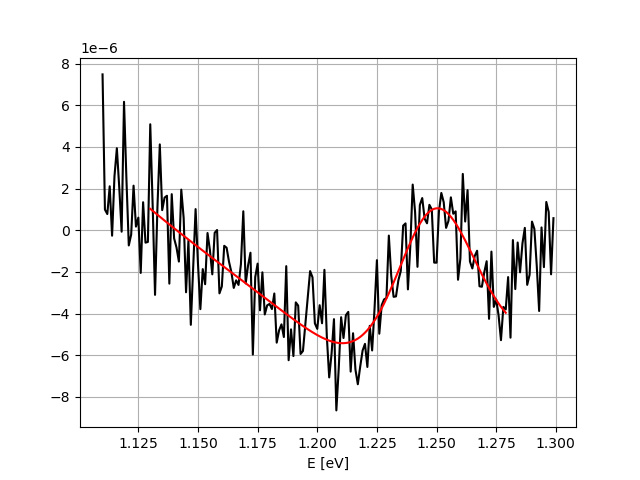

In [16]:
# Fitting range for the first transition
start_energy, stop_energy = 1.13, 1.28

# Fitting params
n = 3
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 20

print(initial_guess)
start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy[start_idx:stop_idx], y_nr[start_idx:stop_idx]
x_contex = energy[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_nr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#ff0000')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_nr['T1'] = Result(
    name = 'PR NR I transition',
    color = '#ff0000',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## II Transition

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.275 eV to 1.36 eV, idx: 176, 261
Params [-3.99559141e-03  6.00913064e-03 -2.25808993e-03  3.56952507e-10
 -1.14941342e+01  1.33488787e+00 -4.46813080e-02]
 Covariance: [[ 4.28259060e-05 -6.56406554e-05  2.51346084e-05 -4.14257270e-12
   2.19458125e-02 -2.19806788e-04  7.13219681e-05]
 [-6.56406554e-05  1.00612589e-04 -3.85269516e-05  6.32727120e-12
  -3.37044467e-02  3.37514722e-04 -1.08533782e-04]
 [ 2.51346084e-05 -3.85269516e-05  1.47533321e-05 -2.41418680e-12
   1.29316303e-02 -1.29471019e-04  4.12551806e-05]
 [-4.14257270e-12  6.32727120e-12 -2.41418680e-12  6.29765572e-19
  -1.69558483e-09  1.79653922e-11 -1.49332316e-11]
 [ 2.19458125e-02 -3.37044467e-02  1.29316303e-02 -1.69558483e-09
   1.29790306e+01 -1.29888644e-01  2.10349998e-02]
 [-2.19806788e-04  3.37514722e-04 -1.29471019e-04  1.79653922e-11
  -1.29888644e-01  1.31212241e-03 -2.43110529e-04]
 [ 7.13219681e-05 -1.08533782e-04  4.12551806e-05 -1.49332316e-11
   2.10349

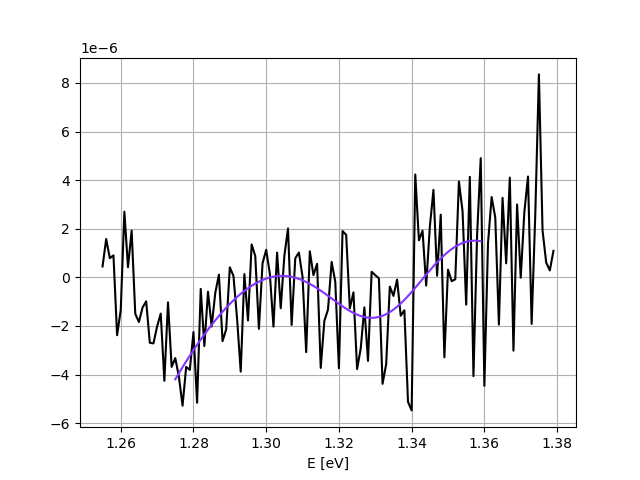

In [17]:
# Fitting range for the first transition
start_energy, stop_energy = 1.275, 1.36

# Fitting params
n = 3
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 20

print(initial_guess)
start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy[start_idx:stop_idx], y_nr[start_idx:stop_idx]
x_contex = energy[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_nr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='#8533ff')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_nr['T2'] = Result(
    name = 'PR NR II transition',
    color = '#8533ff',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## All transitions

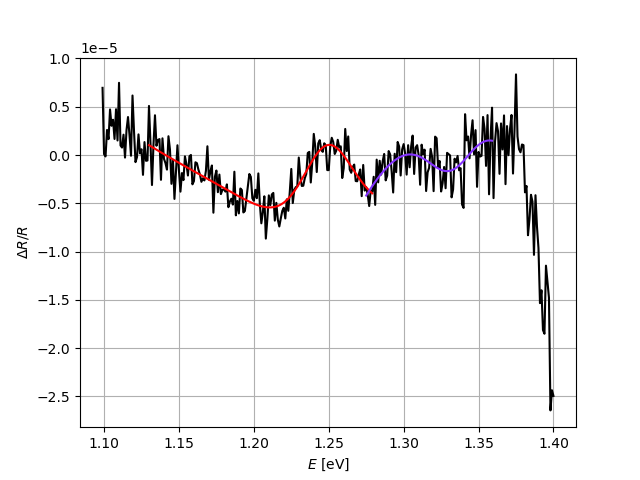

In [18]:
plt.figure()
# Plot base
plt.plot(energy, y_nr, color='black')
# Apply results
for r in global_results_nr.values():
    plt.plot(r.x_fit, r.y_fitted, color=r.color)
plt.xlabel(r'$E $ [eV]')
plt.ylabel(r'$\Delta R / R$')
plt.grid(True)
plt.show()

# Module

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

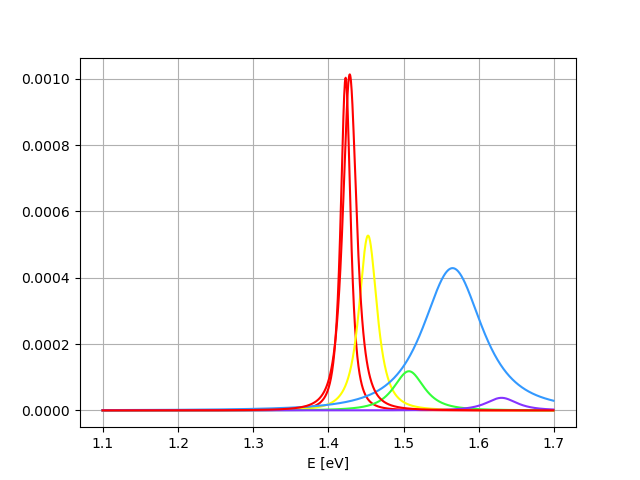

In [19]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.15, 1.35

energy_wr = pl07wr_df['energy']
ac_x_wr = pl07wr_df['AC_X']
ac_y_wr = pl07wr_df['AC_Y']
r_wr = pl07wr_df['AC_R']
r_calc_wr = np.sqrt((ac_x_wr**2)+(ac_y_wr**2))

plt.figure()
# plt.plot(energy_wr, r_wr, color='black')
for r in global_results_wr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    plt.plot(energy_wr, y, color=r.color)
    
r = global_results_wr['T1']
y = fit_module12_calc(r.n, energy_wr, r.fitted_params)
plt.plot(energy_wr, y, color=r.color)

plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Module

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

# Final output

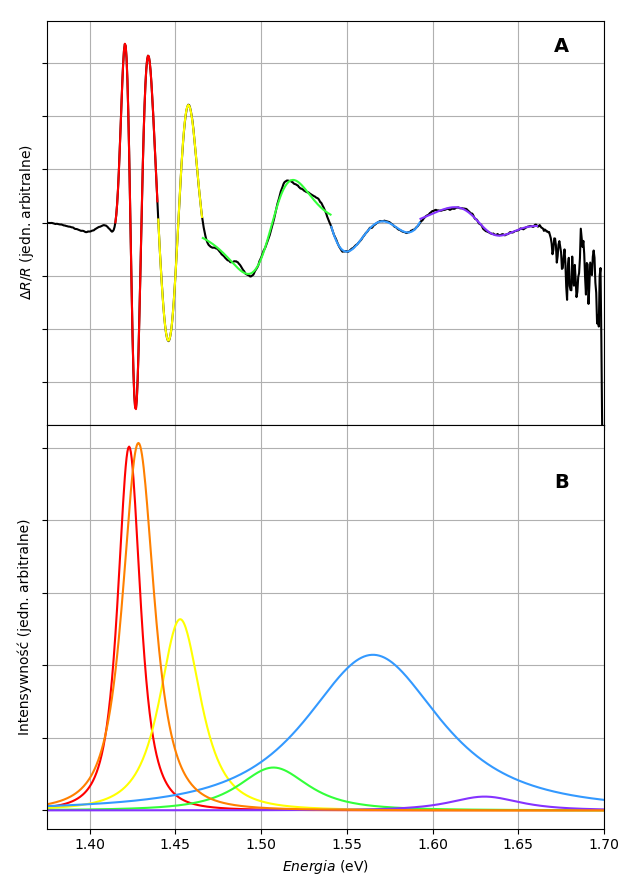

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(2.1*3, 2.97*3), dpi=100)
plt.xlabel(r'$Energia $ (eV)')
plt.tight_layout()

# Remove vertical space
fig.subplots_adjust(hspace=0)

# Plot base
axs[0].grid(True)
axs[0].tick_params(axis='y', labelleft=False)
axs[0].set_ylabel(r'$\Delta R / R$ (jedn. arbitralne)')
axs[0].plot(energy_wr, y_wr, color='black')
axs[0].set_ylim(-0.00038, 0.00038)
axs[0].text(0.91, 0.96, 'A', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Apply PR fit results
for r in global_results_wr.values():
    axs[0].plot(r.x_fit, r.y_fitted, color=r.color)

axs[1].set_ylabel(r'Intensywność (jedn. arbitralne)')
for r in global_results_wr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    axs[1].plot(energy_wr, y, color=r.color)

# Orange peak
r = global_results_wr['T1']
op = fit_module12_calc(r.n, energy_wr, r.fitted_params)
axs[1].plot(energy_wr, op, color='#ff8000')

axs[1].text(0.91, 0.88, 'B', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlim(1.375, 1.7)
plt.grid(True)
plt.show()


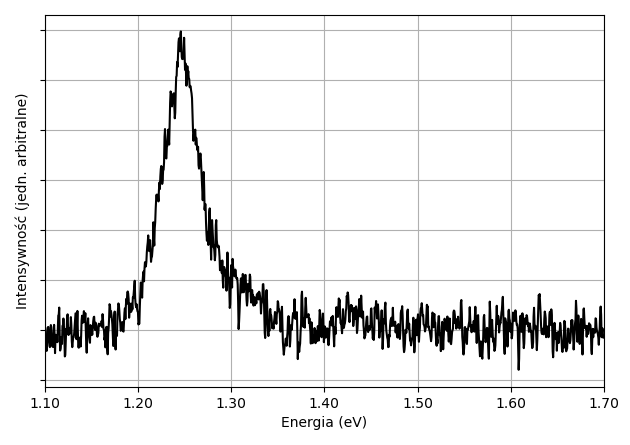

In [21]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']

plt.figure(figsize=(2.1*3, 2.97*1.5),dpi=100)
plt.plot(energy_wr, pl_wr, color='black')
plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlabel('Energia (eV)')
plt.ylabel('Intensywność (jedn. arbitralne)')
plt.grid(True)
plt.xlim(1.10, 1.70)
plt.tight_layout()

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

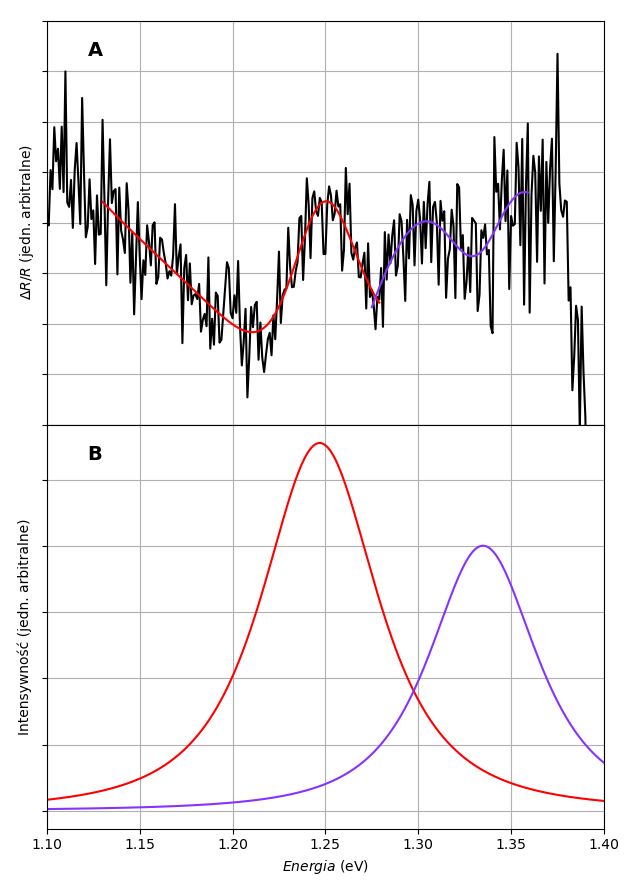

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(2.1*3, 2.97*3), dpi=100)
plt.xlabel(r'$Energia $ (eV)')
plt.tight_layout()

# Remove vertical space
fig.subplots_adjust(hspace=0)

# Plot base
axs[0].grid(True)
axs[0].tick_params(axis='y', labelleft=False)
axs[0].set_ylabel(r'$\Delta R / R$ (jedn. arbitralne)')
axs[0].plot(energy, y_nr, color='black')
axs[0].set_ylim(-1e-5, 1e-5)
axs[0].text(0.073, 0.95, 'A', transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Apply PR fit results
for r in global_results_nr.values():
    axs[0].plot(r.x_fit, r.y_fitted, color=r.color)

axs[1].set_ylabel(r'Intensywność (jedn. arbitralne)')
for r in global_results_nr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    axs[1].plot(energy_wr, y, color=r.color)

axs[1].text(0.073, 0.95, 'B', transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlim(1.1, 1.4)
plt.grid(True)
plt.show()

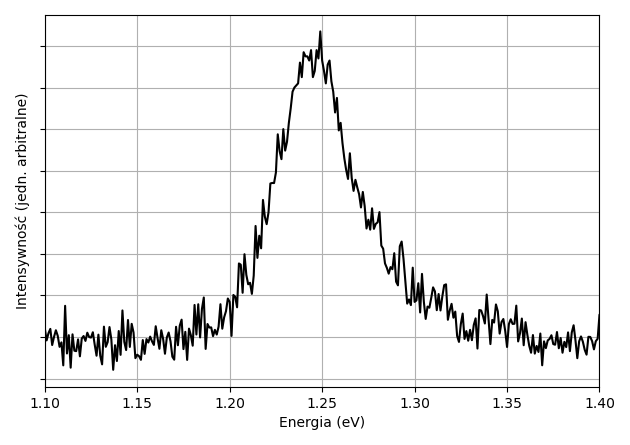

In [23]:
energy_wr = pl25_df['energy']
pl_wr = pl25_df['AC_X']

plt.figure(figsize=(2.1*3, 2.97*1.5),dpi=100)
plt.plot(energy_wr, pl_wr, color='black')
plt.gca().set_yticklabels([])  # Only removes the labels
plt.xlabel('Energia (eV)')
plt.ylabel('Intensywność (jedn. arbitralne)')
plt.grid(True)
plt.xlim(1.1, 1.4)
plt.tight_layout()
plt.show()

In [24]:
for r in global_results_wr.values():
    print(f'Name: {r.name}')
    perr = np.sqrt(np.diag(r.covariance))
    for i, (k, v) in enumerate(r.fitted_params.items()):
        u = perr[i]
        print(f'{k}: {v} \nu({k}): {u}')
    print('\n')


Name: PR WR I transition
A1: 0.942258628929442 
u(A1): 0.7091947879527688
B1: -1.3029331379284388 
u(B1): 0.9927682343123014
C1: 0.4502968721223084 
u(C1): 0.34740400670397265
D1: 1.0392587184341354e-09 
u(D1): 1.4352346145300597e-10
T1: -2.298153573376483 
u(T1): 0.19859462493334612
E1: 1.422980584247827 
u(E1): 0.00027343633733154627
G1: -0.010118162630149247 
u(G1): 0.00016831699099471633
D2: -2.822944186783456e-09 
u(D2): 6.349225813672809e-10
T2: -3.396745593271513 
u(T2): 0.19779605144376972
E2: 1.428415403436448 
u(E2): 0.00034783792300037175
G2: -0.014070847518684239 
u(G2): 0.00073802083357254


Name: PR WR II transition
A1: 2.5253982369828165 
u(A1): 0.12192279528777883
B1: -3.4569329581729065 
u(B1): 0.1678686539398119
C1: 1.1829078798020605 
u(C1): 0.057777490478168235
D1: 3.2604149361402677e-09 
u(D1): 7.498232326444121e-11
T1: -2.709764489181281 
u(T1): 0.040585548928424475
E1: 1.4527835011389094 
u(E1): 0.00014086623635867703
G1: 0.01835545092566912 
u(G1): 8.51689929635

In [25]:
for r in global_results_nr.values():
    print(f'Name: {r.name}')
    perr = np.sqrt(np.diag(r.covariance))
    for i, (k, v) in enumerate(r.fitted_params.items()):
        u = perr[i]
        print(f'{k}: {v} \nu({k}): {u}')
    print('\n')


Name: PR NR I transition
A1: 0.0005410717017123464 
u(A1): 0.0003481795442365678
B1: -0.000866732266734819 
u(B1): 0.0005873456510689299
C1: 0.0003442654605639392 
u(C1): 0.0002473421058538829
D1: 6.134046546584246e-10 
u(D1): 3.2873135140152197e-10
T1: 10.688120238085947 
u(T1): 0.37497453337208814
E1: 1.2469192079332503 
u(E1): 0.004748631223802314
G1: 0.0479840466552216 
u(G1): 0.0071099645722087325


Name: PR NR II transition
A1: -0.003995591412823656 
u(A1): 0.006544150515983343
B1: 0.006009130640678646 
u(B1): 0.010030582699727135
C1: -0.002258089926756233 
u(C1): 0.0038410066454450252
D1: 3.569525074021513e-10 
u(D1): 7.935777038007143e-10
T1: -11.494134216924282 
u(T1): 3.6026421757246423
E1: 1.3348878691711261 
u(E1): 0.036223230196278336
G1: -0.04468130797716128 
u(G1): 0.02012172118734977


